# Introduction to Kalman Filters
This notebook introduces the **Kalman filter**, a recursive algorithm for estimating the state of dynamic systems. We’ll explain the math intuitively, review the necessary linear algebra, and demonstrate applications with Python code.

## 1. Motivation and Context

Case: You are tracking a moving target. You get new position measurement every second. Each measurement is noisy. You can not use FIR/IIR filters because the position keeps changing (you could use those filters if target would stay longer in one place). However you know that the heavy target cannot make 90 degree turns or change speed infinitely, so you do have a good guess where the target is after each elapsed second. Kalman filter takes both into account: (1) knowledge about the possible next position, and (2) the latest measurement data. Additionally, you could have multiple measurement methods summed in: you might get velocity measurement every 5 seconds and additional more accurate position measurement once per minute. Kalman filter can fuse all that information into one position prediction, available at any time.

- Traditional filters (FIR, IIR) process one stream of measurements. 
- Many real systems combine multiple noisy sensors, e.g., GPS + accelerometer.
- Kalman filters keep an **internal model of the physical system**, predicting how the state evolves. Sensors then provide measurements to **correct and enhance** this prediction.

### Key idea:
- Model-based prediction (physics, kinematics)
- Correction with noisy sensor data
- Recursive update of uncertainty

**Applications**: navigation, robotics, tracking, wearables.


## 2. Falling Body Example — From Physics to Matrices
A physical example: a falling object under gravity. We start from continuous-time kinematics and translate them into the **discrete-time** matrices used by the Kalman filter.  

### 2.1. Continuous-Time Model of a Falling Body

We start from the **Newtonian equations of motion** describing vertical motion under constant acceleration due to gravity.

The **continuous-time system** is:

$$
\frac{d}{dt} y(t) = v(t)
$$

$$
\frac{d}{dt} v(t) = a(t)
$$

where  

- $y(t)$: position (m)  
- $v(t)$: velocity (m/s)  
- $a(t)$: acceleration (m/s²)

For a freely falling object under gravity:

$$
a(t) = -g
$$

with $g$ approx 9.81 ${m/s}^2$ directed downward.  

Integrating over time gives:

$$
v(t) = v_0 - g t
$$

$$
y(t) = y_0 + v_0 t - \tfrac{1}{2} g t^2
$$



### 2.2. From Continuous to Discrete Time

To apply the Kalman filter, we use a **discrete-time approximation** with sampling interval \( \Delta t \):

$$
v_{k+1} = v_k + a_k \, \Delta t
$$

$$
y_{k+1} = y_k + v_k \, \Delta t + \tfrac{1}{2} a_k \, \Delta t^2
$$

This forms the **state transition model**, which will later be expressed in matrix form and used inside the Kalman filter.


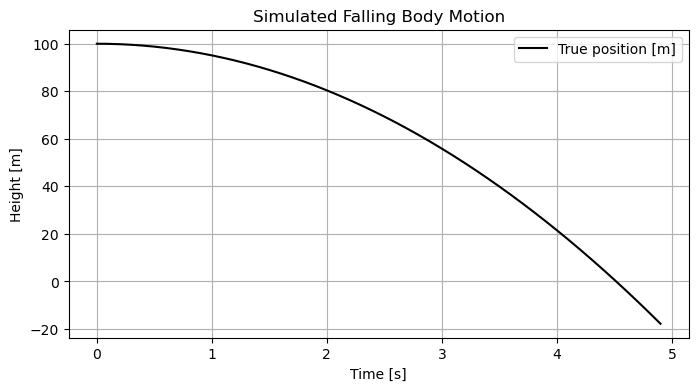

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
dt = 0.1              # time step (s)
n_steps = 50          # number of samples
g = -9.81             # m/s², acceleration due to gravity
t = np.arange(0, n_steps * dt, dt)

# Initialize true state
true_pos, true_vel = [100.0], [0.0]   # start 100 m above ground
rng = np.random.default_rng(1)

# Simulate falling motion
for k in range(1, n_steps):
    v_next = true_vel[-1] + g * dt
    x_next = true_pos[-1] + true_vel[-1]*dt + 0.5 * g * dt**2
    true_vel.append(v_next)
    true_pos.append(x_next)

true_pos = np.array(true_pos)
true_vel = np.array(true_vel)

# Plot the simulated data
plt.figure(figsize=(8,4))
plt.plot(t, true_pos, 'k-', label='True position [m]')
plt.title('Simulated Falling Body Motion')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.legend()
plt.grid(True)
plt.show()

### 2.3. Discrete-Time Kinematics in Matrix Form

We stack position and velocity into the **state vector**:
$$
\mathbf{x}_k =
\begin{bmatrix}
x_k \\
v_k
\end{bmatrix}
$$

From the discrete kinematic equations
$$
\begin{aligned}
x_{k+1} &= x_k + &v_k\,\Delta t &+ \tfrac{1}{2} &a_k\,\Delta t^2 \\
v_{k+1} &= &v_k &+ &a_k\,\Delta t
\end{aligned}
$$

we obtain the **state transition with input** (note that x is bolded):
$$
\mathbf{x}_{k+1} = F\,\mathbf{x}_k + B\,u_k
$$

where
$$
F =
\begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix},
\quad
B =
\begin{bmatrix}
\tfrac{1}{2}\Delta t^2 \\
\Delta t
\end{bmatrix},
\quad
u_k = a_k.
$$

If acceleration is known (e.g., gravity $u_k = -g$), it enters through $B\,u_k$.
If acceleration is uncertain, we model it as **process noise**:
$$
\mathbf{x}_{k+1} = F\,\mathbf{x}_k + B\,u_k + \mathbf{w}_k,
\qquad
\mathbf{w}_k \sim \mathcal{N}(0,Q).
$$

If a sensor measures **position only**, the **measurement model** is
$$
\mathbf{z}_k = H\,\mathbf{x}_k + \mathbf{v}_k,
\qquad
H = \begin{bmatrix}1 & 0\end{bmatrix},
\qquad
\mathbf{v}_k \sim \mathcal{N}(0,R).
$$

### 2.4 Noise models
Kalman filter has two noise estimates:
- **Process noise** adds uncertainty to the model (e.g. wind gusts, drag changes):
  $$\;\;\mathbf{x}_{k+1} = F\,\mathbf{x}_k + B\,u_k + \mathbf{w}_k,\quad \mathbf{w}_k\sim\mathcal N(0, Q).$$
- **Measurement noise** models sensor uncertainty: $$\;\;\mathbf{z}_k = H\,\mathbf{x}_k + \mathbf{v}_k,\; \mathbf{v}_k\sim\mathcal N(0, R).$$

Those noise levels must be estimated during the **filter design** phase.

- **Measurement noise** ($R$) can often be determined from the *repeatability* and *reproducibility* of the sensor measurement chain.  
- **Process noise** ($Q$) is usually more difficult to determine. It depends on how accurately the physical system follows the model and how strongly unmodeled effects disturb it.  
  Process noise can be derived from physical assumptions (e.g., expected maximum acceleration or steering angle) or determined experimentally.

> **Example:**  
> Consider a two-wheeled robot that can turn and drive forward.  
> To assess process noise for straight-line motion, perform a test series where you command the robot to drive **1, 3, and 5 meters** forward.  
> For each trial, record the actual distance traveled and deviation from the intended straight path.  
> Repeat these tests under **different battery charge levels**, **temperatures**, and **floor surface materials**. Add **dust and dirt** on the path.
> The resulting variation provides an estimate of the process noise parameters for your Kalman filter model.

#### Typical Process Deviation Factors

| Category | Example Factors | Effect on Process Noise |
|-----------|-----------------|--------------------------|
| **Mechanical** | Wheel slippage, uneven surface friction, loose drivetrain | Random deviations in acceleration or direction |
| **Electrical** | Variable motor torque with battery voltage or temperature | Drift in predicted velocity or acceleration |
| **Environmental** | Wind, slope, humidity, surface texture | Persistent bias or slowly varying disturbances |
| **Model Simplifications** | Ignoring steering lag, actuator delay, or nonlinearity | Systematic model mismatch |
| **Control Inputs** | Quantization of control signals, update rate jitter | High-frequency uncertainty in acceleration |

By analyzing these factors, you can approximate the **process noise covariance matrix $Q$** to reflect realistic deviations from your mathematical model.


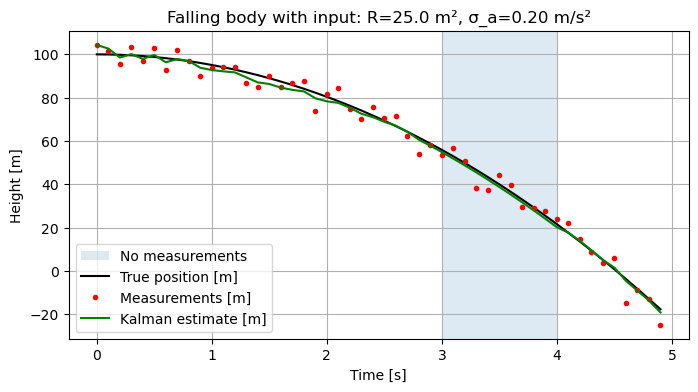

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
dt = 0.1
n_steps = 50
g = -9.81  # m/s^2, upward positive -> gravity is negative
t = np.arange(0, n_steps * dt, dt)

# Generate ground truth (optionally include random acceleration)
rng = np.random.default_rng(1)
sigma_a_true = 0.0  # m/s^2
true_pos, true_vel = [100.0], [0.0]
for k in range(1, n_steps):
    a = g + rng.normal(0.0, sigma_a_true)
    v_next = true_vel[-1] + a*dt
    x_next = true_pos[-1] + true_vel[-1]*dt + 0.5*a*dt**2
    true_vel.append(v_next)
    true_pos.append(x_next)
true_pos = np.array(true_pos)
true_vel = np.array(true_vel)

meas_sigma = 5.0  # m
meas = true_pos + rng.normal(0.0, meas_sigma, size=n_steps)

def kalman_falling(R_var=25.0, sigma_a=0.2):
    """Falling body KF using x=[pos, vel], with input B*u (gravity).
    R_var: measurement variance (m^2)
    sigma_a: assumed std of *random acceleration* (m/s^2) used to build Q
    """
    F = np.array([[1.0, dt],
                  [0.0, 1.0]])
    B = np.array([[0.5*dt**2],
                  [dt]])
    H = np.array([[1.0, 0.0]])
    u = np.array([[g]])

    Q = (sigma_a**2) * np.array([[dt**4/4.0, dt**3/2.0],
                                 [dt**3/2.0, dt**2     ]])
    R = np.array([[R_var]])

    x = np.array([[100.0], [0.0]])
    P = np.diag([1000.0, 1000.0])

    est_pos = []
    for k in range(n_steps):
        # Predict
        x = F @ x + B @ u
        P = F @ P @ F.T + Q

        # --- Update (position measurement) ---
        t_k = t[k]  # current time in seconds

        if not (3.0 <= t_k <= 4.0):   # skip update between 3–4 s
            z = np.array([[meas[k]]])
            y = z - H @ x
            S = H @ P @ H.T + R
            K = P @ H.T @ np.linalg.inv(S)
            x = x + K @ y
            P = (np.eye(2) - K @ H) @ P
        # else: model-only step (no update)

        est_pos.append(x[0,0])

    est_pos = np.array(est_pos)
 
    plt.figure(figsize=(8,4))
    plt.axvspan(3.0, 4.0, alpha=0.15, label='No measurements')
    plt.plot(t, true_pos, 'k-', label='True position [m]')
    plt.plot(t, meas, 'r.', label='Measurements [m]')
    plt.plot(t, est_pos, 'g-', label='Kalman estimate [m]')
    plt.title(f'Falling body with input: R={R_var:.1f} m², σ_a={sigma_a:.2f} m/s²')
    plt.xlabel('Time [s]'); plt.ylabel('Height [m]')
    plt.legend(); plt.grid(True); plt.show()

kalman_falling()

#### Performance explanation

Between 3-4 s, the filter runs only on the model.  
The estimate moves a bit, but stays close to the true path.  
After 4 s, it returns to the true position. 

**Note:**

- Initially kalman state is uncertain, and estimate tracks measurements. Gradually state estimate gets better and the filter trusts model more than measurements. The **Kalman gain** determines how much the filter should trust the new measurement relative to the model prediction.

It is computed as:

$$
K_k = P_{k|k-1} H^\top \big(H P_{k|k-1} H^\top + R\big)^{-1}
$$

**Units recap:**

- $pos$ in **meters (m)**, $vel$ in **m/s**.  
- Input $u_k=g$ in **m/s²** and enters via $B$.  
- $R$ for a position sensor is in **m²**.  
- $\sigma_a$ is **m/s²**; from it we build $Q$ with consistent units.

## 3. Matrices & Kalman Filter Phases

Kalman filters are expressed in matrix form.

- **State vector** $\mathbf{x}$ stacks system variables:  
  $$\mathbf{x} = \begin{bmatrix} \text{position} \\ \text{velocity} \end{bmatrix}$$
  Contains the **current best guess** of the system variables.

- **Covariance matrix** $P$ encodes the **uncertainty** of that guess:  
  $$P = \begin{bmatrix} \sigma^2_{pos} & \text{cov}_{pos,vel} \\ \text{cov}_{pos,vel} & \sigma^2_{vel} \end{bmatrix}.$$
  Diagonals are variances; off-diagonal is covariance (correlation of errors).

- **Process noise covariance** $Q$ and **measurement noise covariance** $R$ tune trust in model vs sensors.  

- **Measurement vector** $\mathbf{z}$ contains sensor readings; **measurement model** $H$ maps state to measurement domain:  
  $$\mathbf{z}_k = H\,\mathbf{x}_k + \mathbf{v}_k,\quad \mathbf{v}_k\sim\mathcal N(0,R).$$

### 3.1 Prediction (model step) with input
$$
\mathbf{x}_{k|k-1} = F\,\mathbf{x}_{k-1|k-1} + B\,u_k
$$
$$
P_{k|k-1} = F\,P_{k-1|k-1}\,F^\top + Q
$$

### 3.2 Update (measurement step)
$$
\mathbf{y}_k = \mathbf{z}_k - H\,\mathbf{x}_{k|k-1}
$$
$$
S_k = H\,P_{k|k-1}\,H^\top + R
$$
$$
K_k = P_{k|k-1}\,H^\top\,S_k^{-1}
$$
$$
\mathbf{x}_{k|k} = \mathbf{x}_{k|k-1} + K_k\,\mathbf{y}_k
$$
$$
P_{k|k} = (I - K_k H)\,P_{k|k-1}
$$


## 4. Sensor Fusion Example (GPS + Accelerometer)
We now estimate a 1D trajectory with state $[pos,\; vel,\; acc]^\top$. The model assumes **approximately constant acceleration**. Two sensors are available each step:
- GPS-like **position** (noisy)
- **Accelerometer** (acceleration)

These are fused by sequential updates with their respective $H$ and $R$.


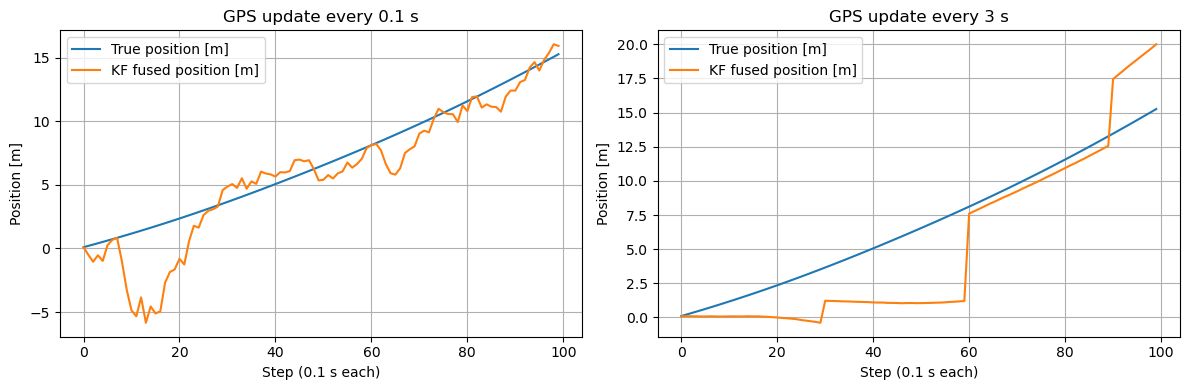

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_sensor_fusion(gps_interval=None, R_gps=25.0, R_acc=0.5, Q_scale=0.1):
    dt = 0.1
    # State: [pos, vel, acc]^T (nearly constant acceleration model)
    F = np.array([[1, dt, 0.5*dt**2],
                  [0,  1,        dt],
                  [0,  0,         1]])
    # Process noise (scaled identity here for simplicity; could derive from jerk noise)
    Q = Q_scale * np.eye(3)
    # Measurements
    H_gps = np.array([[1, 0, 0]])   # position
    H_acc = np.array([[0, 0, 1]])   # acceleration
    Rgps = np.array([[R_gps]])
    Racc = np.array([[R_acc]])

    # Simulate truth
    steps = 100
    pos, vel, acc = 0.0, 1.0, 0.1
    rng = np.random.default_rng(7)
    pos_hist, est_hist = [], []
    x = np.array([[0.0],[0.0],[0.0]])
    P = np.eye(3)*100.0

    gps_every = None
    if gps_interval is not None:
        gps_every = int(gps_interval / dt)  # e.g. 3s -> 30 steps

    for k in range(steps):
        # true motion (slowly varying acceleration)
        acc = 0.1 + 0.02*np.sin(k*dt)
        vel += acc*dt
        pos += vel*dt
        pos_hist.append(pos)

        # Predict
        x = F @ x
        P = F @ P @ F.T + Q

        # GPS update (optional interval)
        do_gps = True
        if gps_every is not None and (k % gps_every != 0):
            do_gps = False
        if do_gps:
            z_gps = pos + rng.normal(0, np.sqrt(R_gps))
            y = np.array([[z_gps]]) - H_gps @ x
            S = H_gps @ P @ H_gps.T + Rgps
            K = P @ H_gps.T @ np.linalg.inv(S)
            x = x + K @ y
            P = (np.eye(3) - K @ H_gps) @ P

        # Accelerometer update
        z_acc = acc + rng.normal(0, np.sqrt(R_acc))
        y = np.array([[z_acc]]) - H_acc @ x
        S = H_acc @ P @ H_acc.T + Racc
        K = P @ H_acc.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(3) - K @ H_acc) @ P

        est_hist.append(x[0,0])

    return pos_hist, est_hist

# --- Run both versions ---
true_pos1, est1 = kalman_sensor_fusion(gps_interval=None)  # every step 0.1 s
true_pos2, est2 = kalman_sensor_fusion(gps_interval=3.0)   # every 3 seconds

# --- Plot side by side ---
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(true_pos1, label='True position [m]')
plt.plot(est1, label='KF fused position [m]')
plt.title('GPS update every 0.1 s')
plt.xlabel('Step (0.1 s each)')
plt.ylabel('Position [m]')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(true_pos2, label='True position [m]')
plt.plot(est2, label='KF fused position [m]')
plt.title('GPS update every 3 s')
plt.xlabel('Step (0.1 s each)')
plt.ylabel('Position [m]')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

### Observations

When the GPS updates every 3 seconds, the Kalman filter relies on the motion model and the accelerometer between updates.
During this time, the estimated position starts to drift because no new GPS data corrects it.
When a GPS update arrives, the filter adjusts back toward the true position.

This shows the **balance between prediction and measurement:**  
frequent updates make the estimate more accurate but noisier,
while rare updates make it smoother but lead to **larger drift** over time.

## 5. Summary
- **Falling body** example uses $F$, the input path $B\,u$, and noise $Q$/$R$ consistently.
- **Sensor fusion** combines heterogeneous sensors by sequential updates with their own $H$ and $R$.

## 6. Further Kalman Filter Variants and Applications

Kalman filters form a **family of estimators** suited for different types of systems and measurement models.  
Below are key extensions and their typical applications.

---

### 6.1. Extended Kalman Filter (EKF)
The **EKF** handles **nonlinear** systems by linearizing the dynamics and measurement models around the current estimate.

**Model form:**
$$
\mathbf{x}_{k+1} = f(\mathbf{x}_k, \mathbf{u}_k) + \mathbf{w}_k, \qquad
\mathbf{z}_k = h(\mathbf{x}_k) + \mathbf{v}_k
$$

At each step:
- Compute Jacobians $F_k = \frac{\partial f}{\partial x}$ and $H_k = \frac{\partial h}{\partial x}$.
- Use them in the standard Kalman predict–update equations.

**Use cases:**
- Mobile robot localization (nonlinear motion + bearing sensors)  
- Attitude estimation from IMU + magnetometer  
- SLAM (Simultaneous Localization and Mapping)  

**Advantages:** simple and widely used.  
**Limitations:** only valid near linearization point; may diverge if initial guess poor.

---

### 6.2. Unscented Kalman Filter (UKF)
The **UKF** avoids explicit linearization.  
Instead, it uses **sigma points** to capture the distribution of possible states and propagates them through the nonlinear functions.

**Key idea:** deterministic sampling of state distribution.

**Use cases:**
- Flight dynamics and UAV state estimation  
- High-speed vehicle tracking  
- Nonlinear control systems  

**Advantages:** higher accuracy than EKF for strong nonlinearities.  
**Limitations:** computationally heavier.

---

### 6.3. Ensemble Kalman Filter (EnKF)
Uses a **statistical ensemble** (a set of state samples) to estimate mean and covariance.

**Use cases:**
- Weather and oceanographic models  
- Large-scale sensor networks  
- High-dimensional dynamical systems  

**Advantages:** scales better to high-dimensional problems.  
**Limitations:** needs large ensembles for good accuracy.

---

### 6.4. Interacting Multiple Model (IMM) Filter
Used when the system can **switch between different dynamic modes**, each modeled by a separate Kalman filter.

**Example:**
A target might move with:
- constant velocity (CV)
- constant acceleration (CA)
- coordinated turn (CT)

Each mode has its own filter; the IMM blends them using **mode probabilities** that evolve over time.

**Use cases:**
- Airborne target tracking  
- Maneuvering vehicles  
- Adaptive motion estimation  

**Advantages:** robust to dynamic changes.  
**Limitations:** higher computational cost; mode design required.

---

### 6.5. Applications Summary

| Application Area | Common Filter Type | Example Sensors |
|------------------|--------------------|-----------------|
| Mobile robots | EKF, UKF | IMU, GPS, wheel encoders |
| Aircraft tracking | IMM, UKF | radar, ADS-B |
| Automotive ADAS | EKF, IMM | radar, lidar, camera |
| Power systems | KF | voltage/current sensors |
| Weather prediction | EnKF | distributed sensor grids |


## 7. **Exercises:**
1. In falling body kalman demo code, change the main loop so that there are no sensor updates between 3.0-4.0 sec. During that time interval the filter runs on model only. How does it perform?
2. Prepare experimental test set to determine the process noise for a robot turning x degrees in place (2-wheel drive). What external factors would you consider?  
3. Assume your 2-wheel robot has compass and IMU sensors. Find suitable components and check their specs: what would be the measurement noise for each (consider the test cases of 1/3/5 meter movement and in-place turns)
4. Modify sensor fusion code so that GPS update happens only every 3 seconds.


### **Answers**

#### **2. Process noise test**

**Test plan:**
1. Make the two-wheel robot turn **x degrees in place** many times.  
2. Record the **real angle** and how far it is from the **expected turn**.  
3. Repeat the test with different **battery levels**, **temperatures**, and **floor types**.  
4. Check how much the turns differ - this difference shows the **process noise (Q)**.

**External factors:**
- Wheel slip or uneven friction  
- Battery charge and motor power  
- Surface type (tile, wood, carpet, dust)  
- Temperature and small floor slope  
- Small control delays or sensor noise   

---

#### **3. Measurement noise (R) estimation**

I decided to use two **STMicroelectronics sensors** for the robot:  
- **IMU:** *LSM6DSOX* (accelerometer + gyroscope)  
- **Compass:** *LIS2MDL* (magnetometer)

**From their datasheets:**  
- *LSM6DSOX* -> about **1.8 mg RMS noise** for the accelerometer and **3.8 mdps/√Hz** for the gyroscope.  
- *LIS2MDL* -> about **3 mG RMS noise** (magnetometer, high-resolution + LPF).

**Based on these values:**  
- During **1 / 3 / 5 meter movements**, measurement noise comes mainly from the **accelerometer** (small acceleration errors) and the **compass** (small drift in heading).  
- During **in-place turns**, measurement noise is mostly from the **gyroscope** and the **compass** (small errors in angular rate and direction).

These numbers are **approximate**, but they show the expected **sensor noise** that appears in the **Kalman filter model**.